### 1.1 Environment Setup  <a class="anchor" id="env-setup"></a>

#### 1.1.1 Importing Modules<a class="anchor" id="imports"></a>

In [1]:
# import modules
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import warnings
import statsmodels.formula.api as smf
from scipy import stats
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

#### 1.1.2 Display Settings<a class="anchor" id="display-setup"></a>

In [2]:
pd.set_option('display.max_columns', None) # display all the columns of a dataframe
# pd.set_option('display.max_rows', 100)     # display 100 rows of a dataframe

#### 1.1.3 Load data<a class="anchor" id="read-file"></a>

In [28]:
data = pd.read_csv("data.csv")

In [4]:
data = data.copy()

#### 1.1.4 Rename columns

In [29]:
# column name change : medication variables
data.columns = data.columns.str.replace("-","_")

#### 1.1.5 Remove duplicate rows -  patinet number column

In [30]:
# duplicate patient_nbr - remove
data.drop_duplicates(['patient_nbr'], inplace = True, ignore_index = True)

In [31]:
# Remove discharge_disposition_id : unique value '13','14','19','20','21' 
is_drop = [item in [13,14,19,20,21] for item in data.discharge_disposition_id]
drop_row_index = [ i for i, is_drop_item in enumerate(is_drop) if is_drop_item]
data.drop(drop_row_index, inplace = True)

# add "11"

#### 1.1.6 Missingness

In [32]:
# "?" == > "Nan" imputation
object_col = data.loc[:,list(data.dtypes == 'object')].columns
for col in object_col:
    data[col] = data[col].str.replace('?', 'Nan')


In [36]:
nan_data = ((data=='Nan').sum() / len(data)).sort_values()
nan_data.sort_values(ascending = False)

weight                      0.960211
medical_specialty           0.481056
payer_code                  0.434975
race                        0.027375
diag_3                      0.017227
diag_2                      0.004124
diag_1                      0.000141
troglitazone                0.000000
metformin_rosiglitazone     0.000000
glimepiride_pioglitazone    0.000000
glipizide_metformin         0.000000
glyburide_metformin         0.000000
insulin                     0.000000
citoglipton                 0.000000
examide                     0.000000
tolazamide                  0.000000
rosiglitazone               0.000000
miglitol                    0.000000
acarbose                    0.000000
change                      0.000000
pioglitazone                0.000000
tolbutamide                 0.000000
glyburide                   0.000000
glipizide                   0.000000
acetohexamide               0.000000
glimepiride                 0.000000
chlorpropamide              0.000000
m

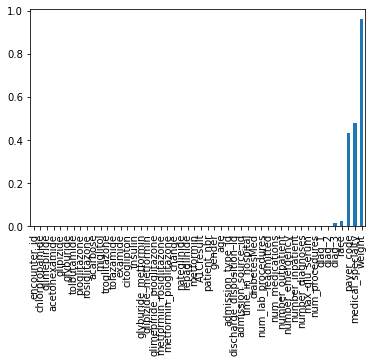

In [38]:
nan_data.plot.bar()

In [9]:
data.shape

(71050, 50)

### 1.2 Preparing Data for Modeling

#### 1.2.1 Grouping Variables by Type

In [10]:
numeric_variables = ['encounter_id', 'patient_nbr','admission_type_id','discharge_disposition_id',
                       'admission_source_id','time_in_hospital','num_lab_procedures','num_procedures',
                       'num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']#13
categorical_variables = ['race','gender','age','weight','payer_code','medical_specialty','diag_1', 'diag_2','diag_3',
                         'max_glu_serum','A1Cresult','change','diabetesMed','readmitted'] #14
medication_variables = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
                       'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',
                       'troglitazone','tolazamide','examide','citoglipton','insulin','glyburide_metformin',
                       'glipizide_metformin','glimepiride_pioglitazone','metformin_rosiglitazone',
                       'metformin_pioglitazone'] #23

In [11]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

#### 1.2.2 drop columns

In [12]:
# Drop columns : id
data.drop(['encounter_id','patient_nbr'], axis = 1, inplace = True)

In [13]:
# Drop : couldn't impute missingness
data.drop(['weight','medical_specialty'], axis = 1, inplace=True)

# Drop : couldn't find valun information
data.drop('payer_code', axis = 1, inplace = True)


In [14]:
#Drop three patients with Gender not specified (they're also missing race and they're all not readmitted which seems weird)
data.drop(data.loc[data.gender=='Unknown/Invalid'].index,inplace=True)

#### 1.2.3 Converting categorical to numeric 

In [16]:
# target value : 0 : <30, 1 : no, >30
readmitted_dict = {'<30' : '1', 'NO': '0', '>30':'0'}
data.readmitted.replace(readmitted_dict, inplace = True)

In [17]:
# age
age_dict = {'[0-10)':0,'[10-20)':10,'[20-30)':20,'[30-40)':30,'[40-50)':40,'[50-60)':50,
           '[60-70)':60,'[70-80)':70,'[80-90)':80,'[90-100)':90}
data.age.replace(age_dict, inplace = True)
                  
#gender
gender_dict = {'Female':0,'Male':1}
data.gender.replace(gender_dict, inplace = True)

# change
change_dict= {'No':0,'Ch':1}
data.change.replace(change_dict, inplace = True)


# diabetesmed
diabetesMed_dict = {'No':0,'Yes':1}
data.diabetesMed.replace(diabetesMed_dict, inplace = True)

In [19]:
# medication variables impute
medication_dict = {'No':0, 'Up': 1, "Steady":1, "Down" :1}
for med_col in medication_variables:
    data[med_col].replace(medication_dict, inplace=True)

#### 1.2.4 Converting categorical to numeric

In [20]:
#This function is specifically to categorize diagnosis ICD9 codes into buckets (Diabetes gets its own bucket)
#https://en.wikipedia.org/wiki/List_of_ICD-9_codes

def convert_icd9_codes(x):
    #Deal with string cases that would prevent conversion to float
    if x=='?':
        return('?')
    if x[0]=='V' or x[0]=='E':
        return('Supplementary')
    # Convert to float and mark diabetes as a special category
    x = float(x)
    if x>=249 and x<251:
        return('Diabetes')
    #Return the type of ICD9 code
    if x>=0 and x<=139:
        return('Infectious')
    if x>=140 and x<=239:
        return('Neoplasms')
    if x>=240 and x<=279:
        return('Endocrine_Immunity')
    if x>=280 and x<=289:
        return('Blood')
    if x>=290 and x<=319:
        return('Mental_Disorders')
    if x>=320 and x<=389:
        return('Nervous_System')
    if x>=390 and x<=459:
        return('Circulatory')
    if x>=460 and x<=519:
        return('Respiratory')
    if x>=520 and x<=579:
        return('Digestive')
    if x>=580 and x<=629:
        return('Genitourinary')
    if x>=630 and x<=679:
        return('Pregnancy')
    if x>=680 and x<=709:
        return('Skin')
    if x>=710 and x<=739:
        return('Muscles_Skeleton')
    if x>=740 and x<=759:
        return('Congenital')
    if x>=760 and x<=779:
        return('Perinatal')
    if x>=780 and x<=799:
        return('Generalized_Symptoms')
    if x>=800 and x<=999:
        return('Injury_Poison')
    else:
        return(None)

In [21]:
#Convert ICD-9 codes to categories
data['diag_1'] = data.diag_1.apply(convert_icd9_codes)
data['diag_2'] = data.diag_2.apply(convert_icd9_codes)
data['diag_3'] = data.diag_3.apply(convert_icd9_codes)

In [22]:
data.to_csv('data_cleaned.csv') 

In [23]:
# set the following columns to int
categorical_int = ['gender', 'age','change', 'diabetesMed','readmitted' ]
medication_variables
data[categorical_int] = data[categorical_int].astype(int)
data[medication_variables] = data[medication_variables].astype(int)

In [24]:
# set the following columns to object
numeric_object = ['admission_type_id','discharge_disposition_id','admission_source_id']
data[numeric_object] = data[numeric_object].astype(object)

In [25]:
# dummified : categorical features :
categorical_features = [f for f in data.columns if data.dtypes[f] == 'object']

In [26]:
# dummified
data_dummified = pd.get_dummies(data = data, columns = categorical_features, drop_first=True)

In [39]:
data_dummified.to_csv('data_cleaned.csv', index = False) 
data_dummified

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted,race_Asian,race_Caucasian,race_Hispanic,race_Nan,race_Other,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25,diag_1_Circulatory,diag_1_Congenital,diag_1_Diabetes,diag_1_Digestive,diag_1_Endocrine_Immunity,diag_1_Generalized_Symptoms,diag_1_Genitourinary,diag_1_Infectious,diag_1_Injury_Poison,diag_1_Mental_Disorders,diag_1_Muscles_Skeleton,diag_1_Neoplasms,diag_1_Nervous_System,diag_1_Pregnancy,diag_1_Respiratory,diag_1_Skin,diag_1_Supplementary,diag_2_Circulatory,diag_2_Congenital,diag_2_Diabetes,diag_2_Digestive,diag_2_Endocrine_Immunity,diag_2_Generalized_Symptoms,diag_2_Genitourinary,diag_2_Infectious,diag_2_Injury_Poison,diag_2_Mental_Disorders,diag_2_Muscles_Skeleton,diag_2_Neoplasms,diag_2_Nervous_System,diag_2_Pregnancy,diag_2_Respiratory,diag_2_Skin,diag_2_Supplementary,diag_3_Circulatory,diag_3_Congenital,diag_3_Diabetes,diag_3_Digestive,diag_3_Endocrine_Immunity,diag_3_Generalized_Symptoms,diag_3_Genitourinary,diag_3_Infectious,diag_3_Injury_Poison,diag_3_Mental_Disorders,diag_3_Muscles_Skeleton,diag_3_Neoplasms,diag_3_Nervous_System,diag_3_Pregnancy,diag_3_Respiratory,diag_3_Skin,diag_3_Supplementary,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm
0,0,0,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,10,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,20,2,11,5,13,2,0,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
3,1,30,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,1,40,1,51,0,8,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,